In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Dropout
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
import time as tm
import datetime
import os
from operator import itemgetter
from numpy import argmax

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
path_log_base = 'Prueba/logs'

set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

filename = '/home/bioml/Projects/PhD/OE1_DL/Auto_curation/auto_curation_class0.fasta.kmers'
class0 = pd.read_csv(filename)

filename = '/home/bioml/Projects/PhD/OE1_DL/Auto_curation/auto_curation_filter1.fasta.kmers'
filter1 = pd.read_csv(filename)

filename = '/home/bioml/Projects/PhD/OE1_DL/Auto_curation/auto_curation_filter2.fasta.kmers'
filter2 = pd.read_csv(filename)

filename = '/home/bioml/Projects/PhD/OE1_DL/Auto_curation/auto_curation_filter3.fasta.kmers'
filter3 = pd.read_csv(filename)

filename = '/home/bioml/Projects/PhD/OE1_DL/Auto_curation/auto_curation_filter4.fasta.kmers'
filter4 = pd.read_csv(filename)

In [6]:
values = filter2['Label'].values
values[values > 1] = 1
filter2['Label'] = values

print(filter2['Label'])

values = filter3['Label'].values
values[values > 1] = 1
filter3['Label'] = values
print(filter3['Label'])

values = filter4['Label'].values
values[values > 1] = 1
filter4['Label'] = values
print(filter4['Label'])

0       1
1       1
2       1
3       1
4       1
       ..
4729    1
4730    1
4731    1
4732    1
4733    1
Name: Label, Length: 4734, dtype: int64
0       1
1       1
2       1
3       1
4       1
       ..
8563    1
8564    1
8565    1
8566    1
8567    1
Name: Label, Length: 8568, dtype: int64
0       1
1       1
2       1
3       1
4       1
       ..
2034    1
2035    1
2036    1
2037    1
2038    1
Name: Label, Length: 2039, dtype: int64


In [7]:
X = class0.drop(['Label'], axis=1).values
X = np.concatenate((X, filter1.drop(['Label'], axis=1).values), axis=0)
X = np.concatenate((X, filter2.drop(['Label'], axis=1).values), axis=0)
X = np.concatenate((X, filter3.drop(['Label'], axis=1).values), axis=0)
X = np.concatenate((X, filter4.drop(['Label'], axis=1).values), axis=0)

Y = class0['Label'].values
Y = np.concatenate((Y, filter1['Label'].values), axis=0)
Y = np.concatenate((Y, filter2['Label'].values), axis=0)
Y = np.concatenate((Y, filter3['Label'].values), axis=0)
Y = np.concatenate((Y, filter4['Label'].values), axis=0)

In [8]:
s = pd.Series(Y)
A=s.value_counts(sort=False)
print(A[0:])

0    56442
1    49215
dtype: int64


In [9]:
# Scaling
scaler = preprocessing.StandardScaler().fit(X)
feature_vectors_scaler = scaler.transform(X)

#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(feature_vectors_scaler, Y, 
                                                                                        test_size=validation_size, 
                                                                                        random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)
feature_vectors=None
label_vectors=None

from joblib import dump, load
dump(scaler, '/home/bioml/Projects/PhD/OE2/full_DL_version/Models/std_scaler_filter.bin', compress=True)

['/home/bioml/Projects/PhD/OE2/full_DL_version/Models/std_scaler_filter.bin']

In [10]:
pca = decomposition.PCA(n_components=0.96 ,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)
dump(pca, '/home/bioml/Projects/PhD/OE2/full_DL_version/Models/std_pca_filter.bin', compress=True)

['/home/bioml/Projects/PhD/OE2/full_DL_version/Models/std_pca_filter.bin']

In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [106]:
def metrics(Y_validation,predictions):
    classes = len(np.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 25},fmt='') # font size  
    #plt.savefig("/content/drive/Shareddrives/Prueba/FNN_CM",  bbox_inches='tight',dpi=500)
    plt.show()

In [103]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0),linewidth=3.5)
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0),linewidth=3.5)
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0),linewidth=3.5) #Test
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='best')
        plt.grid('on')
        #plt.savefig("/content/drive/Shareddrives/Prueba/FNN_FINAL1",  bbox_inches='tight',dpi=500)
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0),linewidth=3.5)
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0),linewidth=3.5)
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0),linewidth=3.5) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='best')
        plt.grid('on')
        #plt.savefig("/content/drive/Shareddrives/Prueba/FNN_FINAL2",  bbox_inches='tight',dpi=500)
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [14]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_testPCAScaler, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [15]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [97]:
def InpactorFNN_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(400,activation="relu")(inputs)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    #layer 2
    layers = tf.keras.layers.Dense(400,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    #layer 3
    layers = tf.keras.layers.Dense(400,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    #layer 3
    layers = tf.keras.layers.Dense(400,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layers = tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)

    # layer 4
    predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2242)]            0         
_________________________________________________________________
dense (Dense)                (None, 400)               897200    
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600  

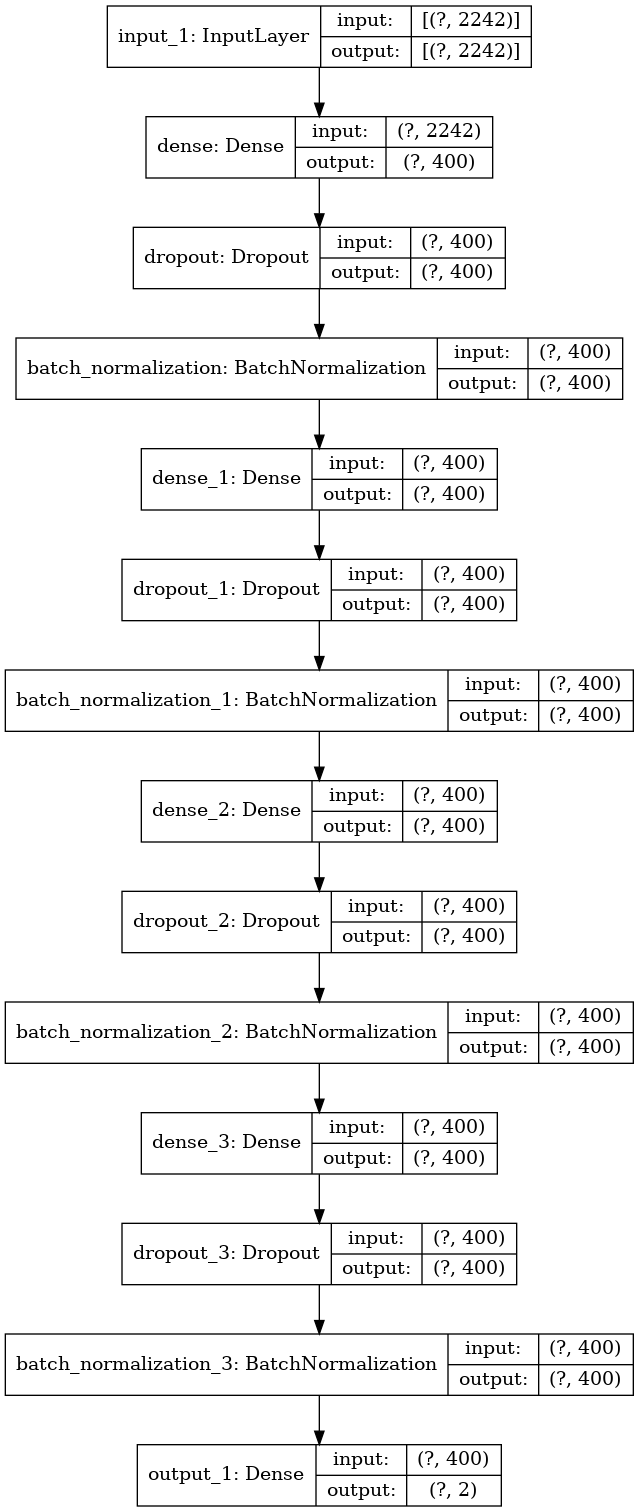

In [98]:
# arquitectura a afinar
model = InpactorFNN_Net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [99]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_trainScaler, num_classes=2)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=2)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=2)

In [100]:
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "InpactorFNN")

Epoch 1/200
661/661 [==============================] - 3s 5ms/step - loss: 0.3500 - f1_m: 0.8523 - val_loss: 0.2420 - val_f1_m: 0.9060
Epoch 2/200
661/661 [==============================] - 3s 5ms/step - loss: 0.2272 - f1_m: 0.9113 - val_loss: 0.2294 - val_f1_m: 0.9096
Epoch 3/200
661/661 [==============================] - 3s 5ms/step - loss: 0.1772 - f1_m: 0.9322 - val_loss: 0.2389 - val_f1_m: 0.9110
Epoch 4/200
661/661 [==============================] - 3s 5ms/step - loss: 0.1478 - f1_m: 0.9435 - val_loss: 0.2439 - val_f1_m: 0.9122
Epoch 5/200
661/661 [==============================] - 3s 5ms/step - loss: 0.1215 - f1_m: 0.9536 - val_loss: 0.2547 - val_f1_m: 0.9138
Epoch 6/200
661/661 [==============================] - 3s 5ms/step - loss: 0.1035 - f1_m: 0.9608 - val_loss: 0.2805 - val_f1_m: 0.9101
Epoch 7/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0906 - f1_m: 0.9651 - val_loss: 0.2915 - val_f1_m: 0.9128
Epoch 8/200
661/661 [==============================] - 

661/661 [==============================] - 3s 5ms/step - loss: 0.0056 - f1_m: 0.9981 - val_loss: 0.7047 - val_f1_m: 0.9137
Epoch 122/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0065 - f1_m: 0.9979 - val_loss: 0.6863 - val_f1_m: 0.9150
Epoch 123/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0064 - f1_m: 0.9979 - val_loss: 0.7256 - val_f1_m: 0.9140
Epoch 124/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0064 - f1_m: 0.9978 - val_loss: 0.6997 - val_f1_m: 0.9129
Epoch 125/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0057 - f1_m: 0.9983 - val_loss: 0.6387 - val_f1_m: 0.9129
Epoch 126/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0065 - f1_m: 0.9979 - val_loss: 0.6783 - val_f1_m: 0.9154
Epoch 127/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0073 - f1_m: 0.9976 - val_loss: 0.6323 - val_f1_m: 0.9146
Epoch 128/200
661/661 [==============================] 

Epoch 181/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0050 - f1_m: 0.9984 - val_loss: 0.6284 - val_f1_m: 0.9124
Epoch 182/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0041 - f1_m: 0.9987 - val_loss: 0.6455 - val_f1_m: 0.9095
Epoch 183/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0047 - f1_m: 0.9984 - val_loss: 0.6595 - val_f1_m: 0.9112
Epoch 184/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0039 - f1_m: 0.9987 - val_loss: 0.7105 - val_f1_m: 0.9136
Epoch 185/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0045 - f1_m: 0.9987 - val_loss: 0.6352 - val_f1_m: 0.9127
Epoch 186/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0046 - f1_m: 0.9985 - val_loss: 0.6509 - val_f1_m: 0.9130
Epoch 187/200
661/661 [==============================] - 3s 5ms/step - loss: 0.0039 - f1_m: 0.9987 - val_loss: 0.6479 - val_f1_m: 0.9132
Epoch 188/200
661/661 [==================

{'loss': 0.7953458428382874, 'f1_m': 0.9123865962028503}

In [101]:
# Fit the model
Final_Results_Test(log_Dir)

saved-model-001-0.9060.hdf5
Loss=0.2497 y F1-Score=0.9025

saved-model-002-0.9096.hdf5
Loss=0.2338 y F1-Score=0.9095

saved-model-003-0.9110.hdf5
Loss=0.2506 y F1-Score=0.9103

saved-model-004-0.9122.hdf5
Loss=0.2528 y F1-Score=0.9084

saved-model-005-0.9138.hdf5
Loss=0.2713 y F1-Score=0.9111

saved-model-006-0.9101.hdf5
Loss=0.2971 y F1-Score=0.9083

saved-model-007-0.9128.hdf5
Loss=0.3113 y F1-Score=0.9079

saved-model-008-0.9124.hdf5
Loss=0.3175 y F1-Score=0.9085

saved-model-009-0.9120.hdf5
Loss=0.3098 y F1-Score=0.9075

saved-model-010-0.9097.hdf5
Loss=0.3332 y F1-Score=0.9105

saved-model-011-0.9134.hdf5
Loss=0.3364 y F1-Score=0.9110

saved-model-012-0.9144.hdf5
Loss=0.3617 y F1-Score=0.9123

saved-model-013-0.9153.hdf5
Loss=0.3634 y F1-Score=0.9145

saved-model-014-0.9116.hdf5
Loss=0.3918 y F1-Score=0.9107

saved-model-015-0.9131.hdf5
Loss=0.4135 y F1-Score=0.9100

saved-model-016-0.9121.hdf5
Loss=0.3938 y F1-Score=0.9110

saved-model-017-0.9150.hdf5
Loss=0.4101 y F1-Score=0.908

Loss=0.6511 y F1-Score=0.9112

saved-model-141-0.9130.hdf5
Loss=0.7447 y F1-Score=0.9116

saved-model-142-0.9111.hdf5
Loss=0.6731 y F1-Score=0.9148

saved-model-143-0.9118.hdf5
Loss=0.7025 y F1-Score=0.9140

saved-model-144-0.9117.hdf5
Loss=0.7126 y F1-Score=0.9142

saved-model-145-0.9111.hdf5
Loss=0.7000 y F1-Score=0.9100

saved-model-146-0.9120.hdf5
Loss=0.7027 y F1-Score=0.9125

saved-model-147-0.9117.hdf5
Loss=0.6467 y F1-Score=0.9115

saved-model-148-0.9131.hdf5
Loss=0.7820 y F1-Score=0.9129

saved-model-149-0.9125.hdf5
Loss=0.7155 y F1-Score=0.9136

saved-model-150-0.9121.hdf5
Loss=0.6567 y F1-Score=0.9107

saved-model-151-0.9115.hdf5
Loss=0.7068 y F1-Score=0.9129

saved-model-152-0.9150.hdf5
Loss=0.6830 y F1-Score=0.9127

saved-model-153-0.9129.hdf5
Loss=0.7303 y F1-Score=0.9123

saved-model-154-0.9134.hdf5
Loss=0.6917 y F1-Score=0.9114

saved-model-155-0.9133.hdf5
Loss=0.6666 y F1-Score=0.9113

saved-model-156-0.9140.hdf5
Loss=0.6729 y F1-Score=0.9113

saved-model-157-0.9108.hd

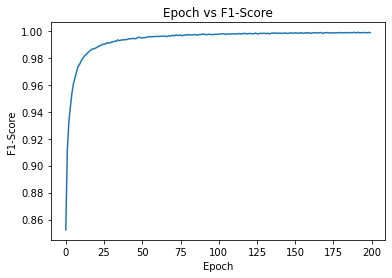

Test Accuracy 0.9153134226799011, Época:112

Test Accuracy 0.9148414134979248, Época:103

Test Accuracy 0.9148414134979248, Época:142

Test Accuracy 0.914746880531311, Época:35

Test Accuracy 0.9146525859832764, Época:98

Test Accuracy 0.9145581722259521, Época:185

Test Accuracy 0.9144637584686279, Época:13

Test Accuracy 0.9144637584686279, Época:162

Test Accuracy 0.9144637584686279, Época:166

Test Accuracy 0.9143693447113037, Época:87


Train Accuracy 0.9989362955093384, Época:192

Train Accuracy 0.9988080859184265, Época:199

Train Accuracy 0.9987726211547852, Época:190

Train Accuracy 0.9987471699714661, Época:189

Train Accuracy 0.9987353682518005, Época:180

Train Accuracy 0.9987353682518005, Época:187

Train Accuracy 0.9986999034881592, Época:168

Train Accuracy 0.9986880421638489, Época:179

Train Accuracy 0.9986880421638489, Época:184

Train Accuracy 0.9986762404441833, Época:182


Validation F1-Score 0.9172653555870056, Época:189

Validation F1-Score 0.9170448780059814, Ép

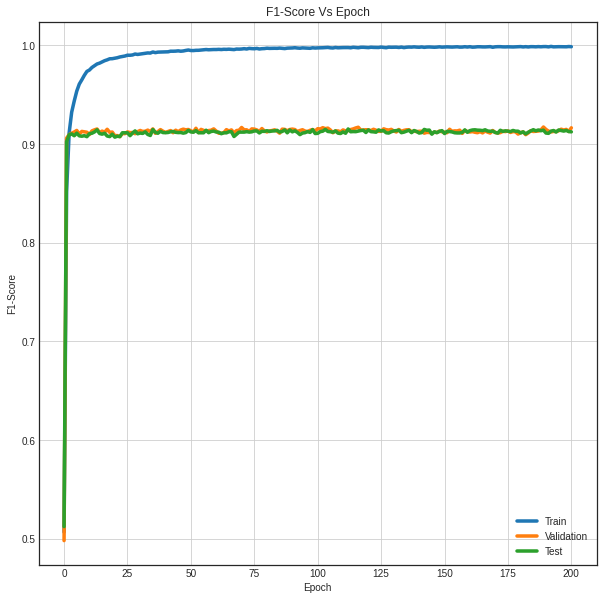

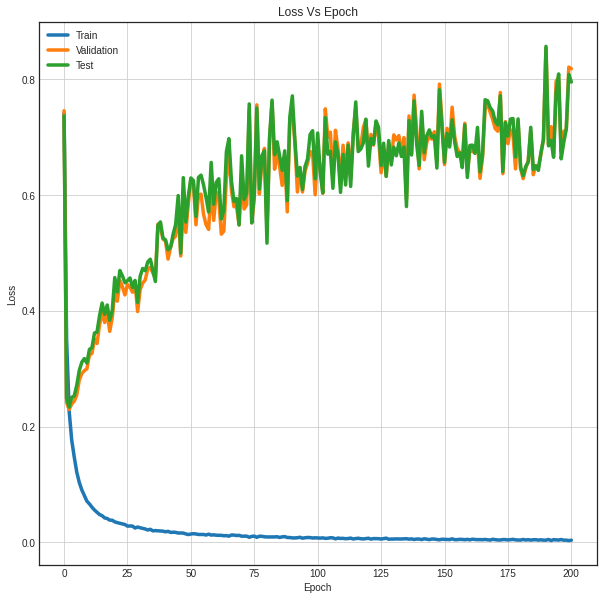

In [104]:
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

Baseline Error train: 0.08%
Baseline Error dev: 8.62%
Baseline Error test: 8.47%
Accuracy: 0.9992191659272405
F1 score: 0.9992191431148291
Recall: 0.9992191659272405
Precision: 0.9992194845334011

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45130
           1       1.00      1.00      1.00     39395

    accuracy                           1.00     84525
   macro avg       1.00      1.00      1.00     84525
weighted avg       1.00      1.00      1.00     84525


 confusion matrix:
 [[45115    15]
 [   51 39344]]


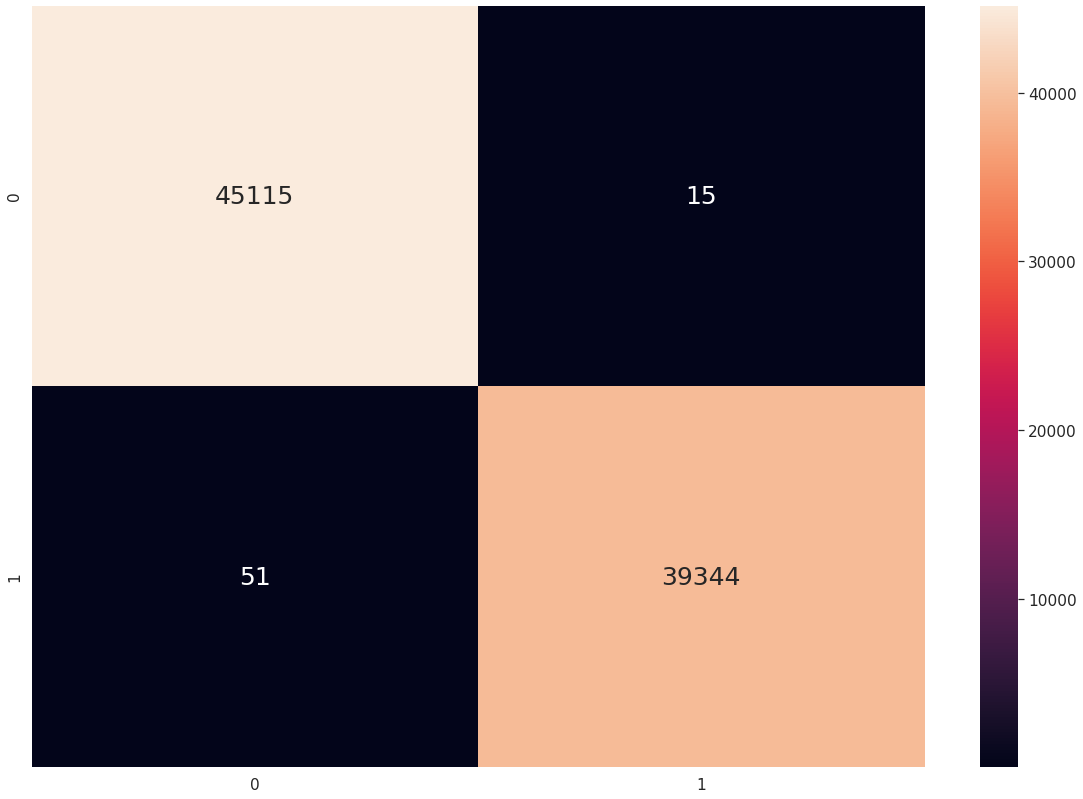

Accuracy: 0.913590762824153
F1 score: 0.913415836745091
Recall: 0.913590762824153
Precision: 0.9142992380826285

 clasification report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      5600
           1       0.93      0.88      0.91      4966

    accuracy                           0.91     10566
   macro avg       0.92      0.91      0.91     10566
weighted avg       0.91      0.91      0.91     10566


 confusion matrix:
 [[5270  330]
 [ 583 4383]]


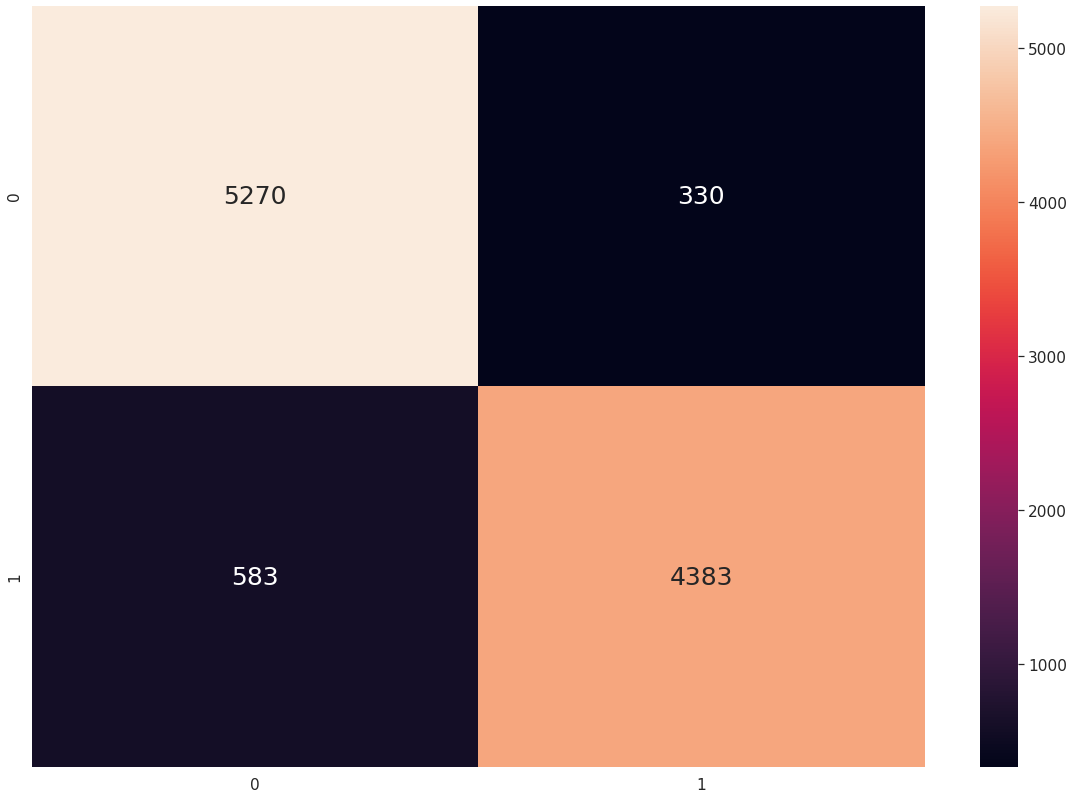

Accuracy: 0.9151050539466212
F1 score: 0.914867539136925
Recall: 0.9151050539466212
Precision: 0.9158708016553624

 clasification report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      5712
           1       0.93      0.88      0.90      4854

    accuracy                           0.92     10566
   macro avg       0.92      0.91      0.91     10566
weighted avg       0.92      0.92      0.91     10566


 confusion matrix:
 [[5400  312]
 [ 585 4269]]


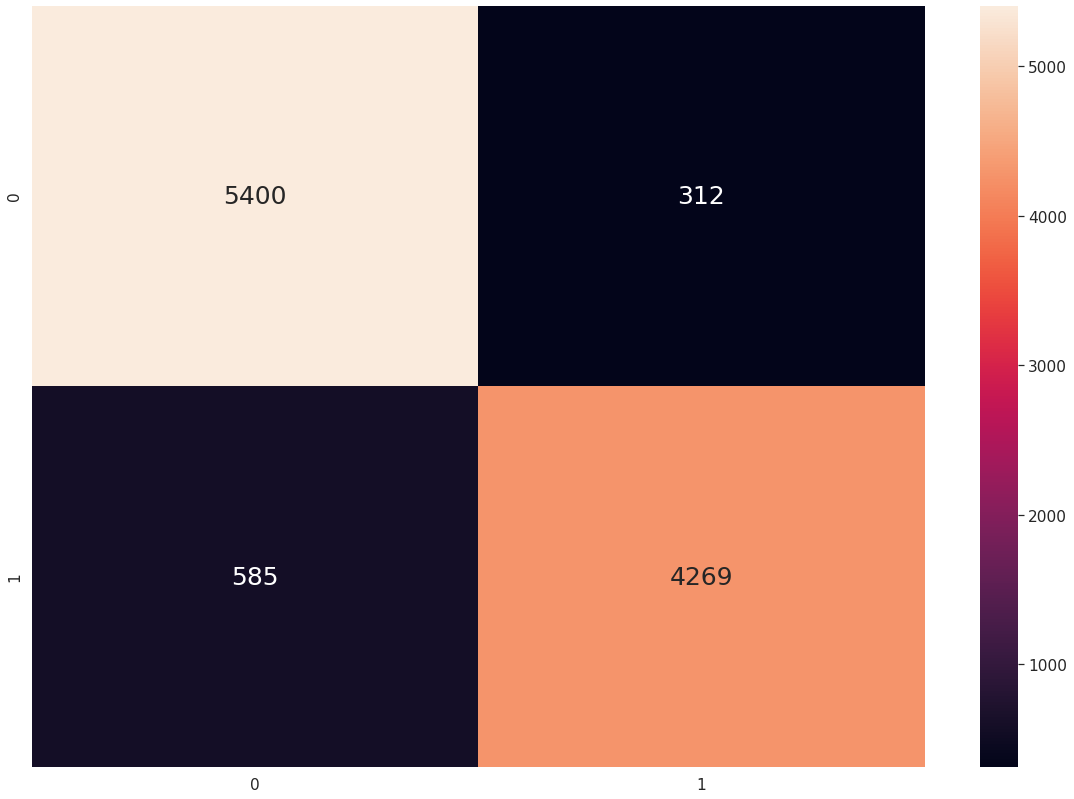

In [107]:
model = tf.keras.models.load_model(log_Dir+'/saved-model-112-0.9137.hdf5', custom_objects={'f1_m':f1_m})
scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_trainScaler, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

In [108]:
#ROC-AUC
def ROC(model,classes):
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
    return visualizer.poof()      

## Computing AUROC and ROC curve values

In [109]:
from sklearn.metrics import roc_curve, roc_auc_score

### Print AUROC scores

In [110]:
predictions1 = model.predict(X_trainPCAScaler)
predictions1=predictions1[:, 1]
predictions2 = model.predict(X_validationPCAScaler)
predictions2=predictions2[:, 1]
predictions3 = model.predict(X_testPCAScaler)
predictions3=predictions3[:, 1]

r_auc1 = roc_auc_score(Y_trainScaler, predictions1)
print('Train Prediction: AUROC = %.3f' % (r_auc1))
r_auc2 = roc_auc_score(Y_dev, predictions2)
print('Validation Prediction: AUROC = %.3f' % (r_auc2))
r_auc3 = roc_auc_score(Y_test, predictions3)
print('Test Prediction: AUROC = %.3f' % (r_auc3))



Train Prediction: AUROC = 1.000
Validation Prediction: AUROC = 0.960
Test Prediction: AUROC = 0.960


Otra manera de obtener AUROC

In [111]:
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, predictions3, pos_label=1)
area2=auc(fpr, tpr)
print(area2)

0.9604310538595332


### Plot the ROC curve

In [112]:
r_fpr1, r_tpr1, _ = roc_curve(Y_trainScaler, predictions1)
r_fpr2, r_tpr2, _ = roc_curve(Y_dev, predictions2)
r_fpr3, r_tpr3, _ = roc_curve(Y_test, predictions3)

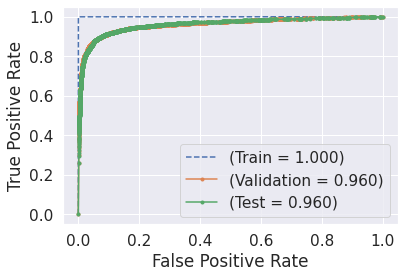

In [114]:

plt.grid('on')
plt.plot(r_fpr1, r_tpr1, linestyle='--', label='(Train = %0.3f)' % r_auc1)
plt.plot(r_fpr2, r_tpr2, marker='.', label='(Validation = %0.3f)' % r_auc2)
plt.plot(r_fpr3, r_tpr3, marker='.', label='(Test = %0.3f)' % r_auc3)

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
plt.grid('on')
#plt.savefig("/content/drive/Shareddrives/Prueba/ROC",  bbox_inches='tight',dpi=500)

# Show plot


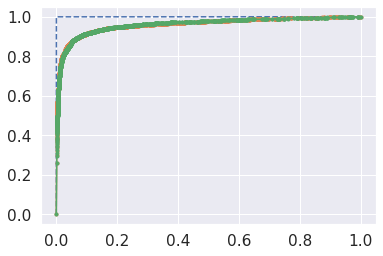

In [115]:
plt.plot(r_fpr1, r_tpr1, linestyle='--', label='(Train = %0.3f)' % r_auc1)
plt.plot(r_fpr2, r_tpr2, marker='.', label='(Validation = %0.3f)' % r_auc2)
plt.plot(r_fpr3, r_tpr3, marker='.', label='(Test = %0.3f)' % r_auc3)

### Plot Precision - Recall Curve

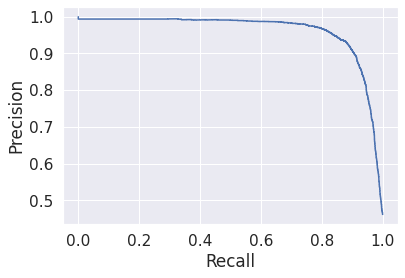

In [117]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(Y_test, predictions3)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
#plt.savefig("/content/drive/Shareddrives/Prueba/PR",  bbox_inches='tight',dpi=500)

### Calculate AUPR

In [118]:
from sklearn.metrics import auc
area = auc(recall, precision)
print(area)

0.9618886017944264


### Tasa de falsos positivos

In [119]:
from sklearn.metrics import recall_score
predictions3 = model.predict(X_testPCAScaler)
tpr = recall_score(Y_test, [argmax(x) for x in predictions])   # it is better to name it y_test 
# to calculate, tnr we need to set the positive label to the other class
# I assume your negative class consists of 0, if it is -1, change 0 below to that value
tnr = recall_score(Y_test, [argmax(x) for x in predictions], pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr

In [120]:
print("Tasa de falsos positivos",fpr)

Tasa de falsos positivos 0.054621848739495826
